In [102]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
import os,sys
import io
from PIL import Image
import tensorflow as tf
from IPython.display import clear_output
import tensorflow_datasets as tfds
import tensorflow.io as tfio
from glob import glob
import time
import datetime

%load_ext autoreload
%autoreload 2

AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Tensorflow ver. 2.7.0


In [29]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

## Creating our Dataloader

In [79]:
SEED = 42

dataset_path = "training/" 
training_data = "images/"
val_data = "test_set_images/"

# Image size that we are going to use
IMG_SIZE = 224
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Scene Parsing has 150 classes + `not labeled`
N_CLASSES = 2

In [80]:
TRAINSET_SIZE = len(glob(dataset_path + training_data + "*.png"))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")
print(dataset_path + training_data + "*.png")


Groundtruth_SIZE = len(glob(dataset_path + "groundtruth/" + "*.png"))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")
print(dataset_path + training_data + "*.png")



VALSET_SIZE = len(glob(val_data + "*.png"))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")


The Training Dataset contains 100 images.
training/images/*.png
The Training Dataset contains 100 images.
training/images/*.png
The Validation Dataset contains 50 images.


In [81]:
from helper_unet import parse_image

train_dataset = tf.data.Dataset.list_files(dataset_path + training_data + "*.png", seed=SEED)
train_dataset = train_dataset.map(parse_image)
print(len(train_dataset))

val_dataset = tf.data.Dataset.list_files(val_data + "*.png", seed=SEED)
val_dataset =val_dataset.map(parse_image)
print(len(val_dataset))

100
50


## Applying some transformations to our dataset

In [82]:
from helper_unet import load_image_test, load_image_train

BATCH_SIZE = 32

BUFFER_SIZE = 1000

dataset = {"train": train_dataset, "val": val_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

print(dataset['train'])
print(dataset['val'])


<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.float32)>


##  Visualizing the Dataset

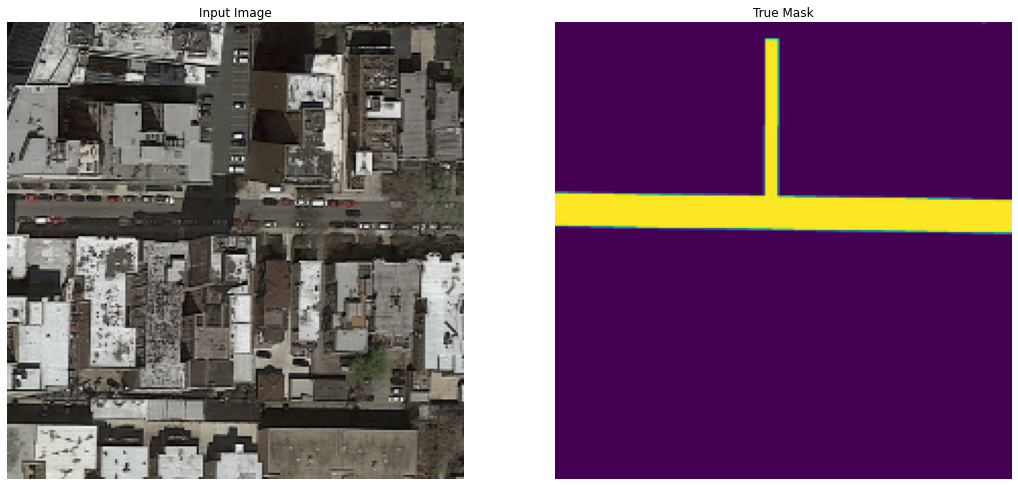

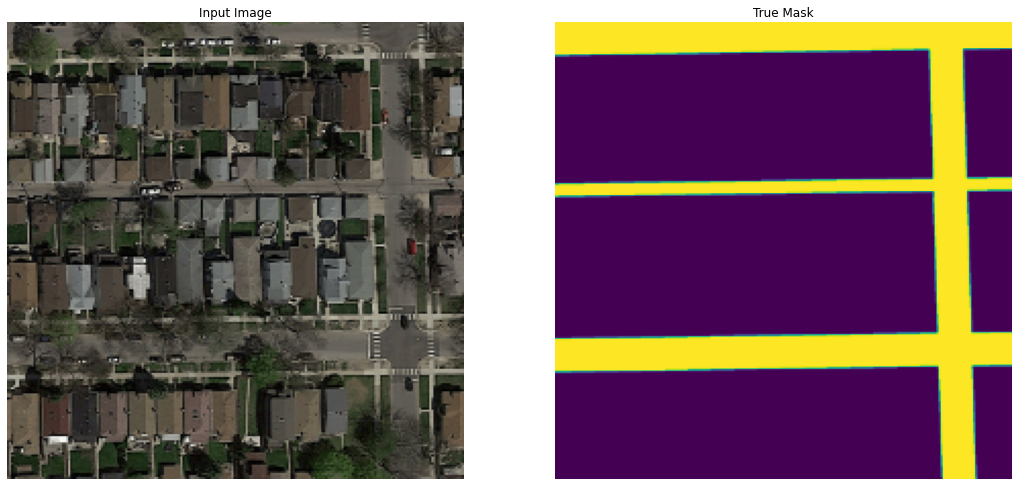

In [83]:
from helper_unet import display_sample

for image, mask in dataset['train'].take(2):
    sample_image, sample_mask = image, mask
    display_sample([sample_image[0], sample_mask[0]])


## Developing the Model (UNet) Using Keras Functional API


In [94]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False)

## A partir de ce moment je suis perdue. Charlotte 
#Il faut regarder quelle architecture on veut implementer pour downsample et apres upsample

#Create the feature extraction model
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # (None, 112, 112, 96)
    'block_3_expand_relu',   # (None, 56, 56, 144)
    'block_6_expand_relu',   # (None, 28, 28, 192)
    'block_13_expand_relu',  # (None, 14, 14, 576)
    'block_16_project',      # (None, 7, 7, 320) 
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False
base_model_outputs

[<KerasTensor: shape=(None, 112, 112, 96) dtype=float32 (created by layer 'block_1_expand_relu')>,
 <KerasTensor: shape=(None, 56, 56, 144) dtype=float32 (created by layer 'block_3_expand_relu')>,
 <KerasTensor: shape=(None, 28, 28, 192) dtype=float32 (created by layer 'block_6_expand_relu')>,
 <KerasTensor: shape=(None, 14, 14, 576) dtype=float32 (created by layer 'block_13_expand_relu')>,
 <KerasTensor: shape=(None, 7, 7, 320) dtype=float32 (created by layer 'block_16_project')>]

In [95]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64x96
    'block_3_expand_relu',   # 32x32x144
    'block_6_expand_relu',   # 16x16x192
    'block_13_expand_relu',  # 8x8x576
    'block_16_project',      # 4x4x320
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False
base_model_outputs

[<KerasTensor: shape=(None, 64, 64, 96) dtype=float32 (created by layer 'block_1_expand_relu')>,
 <KerasTensor: shape=(None, 32, 32, 144) dtype=float32 (created by layer 'block_3_expand_relu')>,
 <KerasTensor: shape=(None, 16, 16, 192) dtype=float32 (created by layer 'block_6_expand_relu')>,
 <KerasTensor: shape=(None, 8, 8, 576) dtype=float32 (created by layer 'block_13_expand_relu')>,
 <KerasTensor: shape=(None, 4, 4, 320) dtype=float32 (created by layer 'block_16_project')>]

In [105]:

up_stack = [
    upsample(512, 3),  # 7x7 -> 14x14
    upsample(256, 3),  # 14x14 -> 28x28
    upsample(128, 3),  # 28x28 -> 56x56
    upsample(64, 3),   # 56x56 -> 112x112
]

NameError: name 'upsample' is not defined